In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import solve

Используя явную и неявную конечно-разностные схемы, а также схему Кранка - Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x,t)$. Исследовать зависимость погрешности от сеточных параметров $\tau, h$.

$\frac{\partial u}{\partial t} = a\frac{\partial^2 u}{\partial x^2} + cu, a>0, c<0$

$u_x(0,t)=exp((c-a)t)$,

$u(\frac{\pi}{2},t) = exp((c-a)t)$,

$u(x,0)=\sin{x}$

Аналитическое решение: $U(x,t)=exp((c-a)t)\sin{x}$

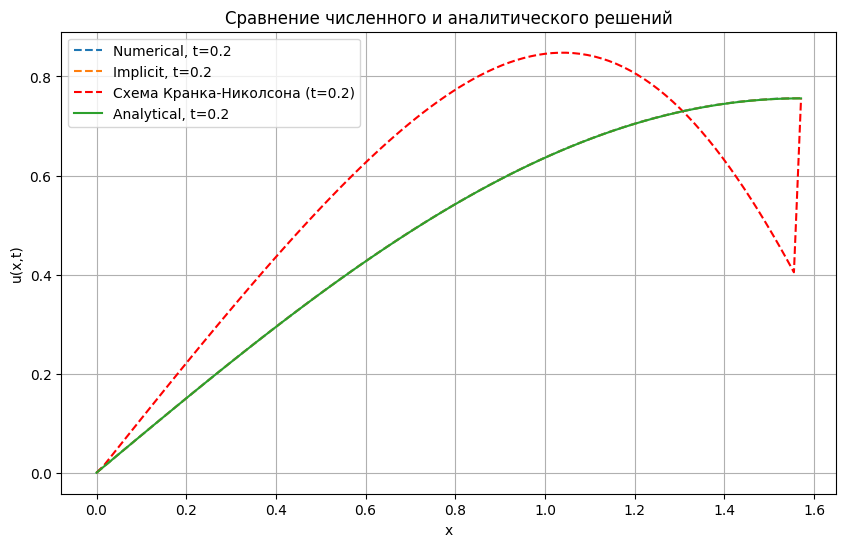

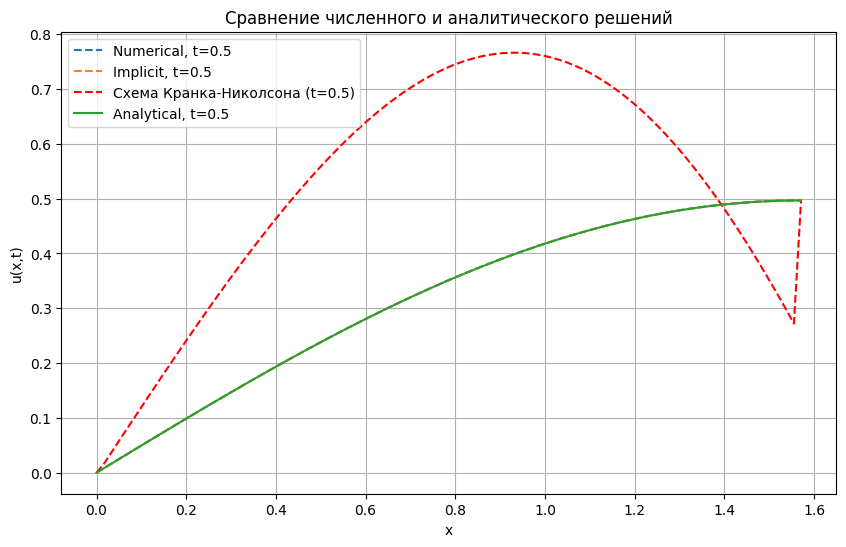

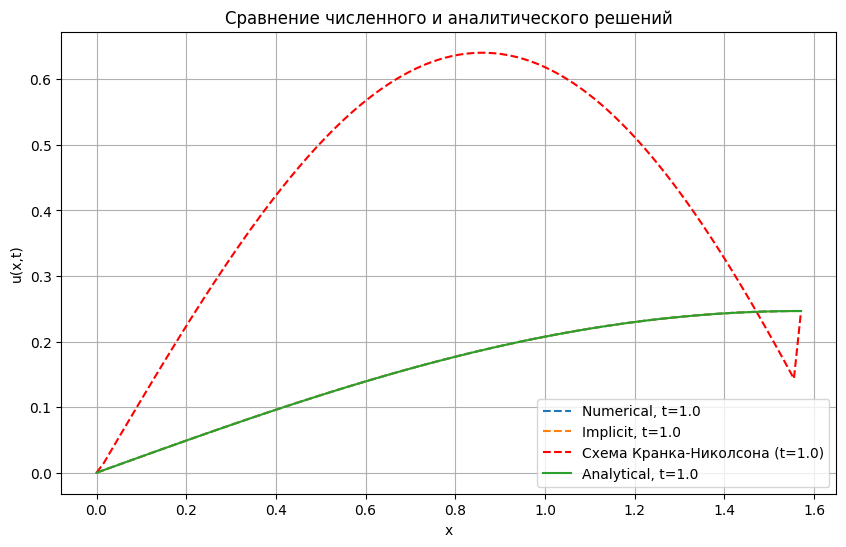

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve

def decompose_to_LU(a):
    # Создаём пустую LU-матрицу той же размерности, что и матрица a
    lu_matrix = np.matrix(np.zeros([a.shape[0], a.shape[1]]))
    n = a.shape[0]

    for k in range(n):
        # Вычисляем остаточные элементы k-ой строки
        for j in range(k, n):
            lu_matrix[k, j] = a[k, j] - lu_matrix[k, :k] * lu_matrix[:k, j]
        # Вычисляем остаточные элементы k-ого столбца
        for i in range(k + 1, n):
            lu_matrix[i, k] = (a[i, k] - lu_matrix[i, :k] * lu_matrix[:k, k]) / lu_matrix[k, k]

    return lu_matrix

def solve_LU(lu_matrix, b):
    # Получаем вектор y, решая L*y = b
    y = np.matrix(np.zeros([lu_matrix.shape[0], 1]))
    for i in range(y.shape[0]):
        y[i, 0] = b[i] - lu_matrix[i, :i] * y[:i]

    # Получаем вектор x, решая U*x = y
    x = np.matrix(np.zeros([lu_matrix.shape[0], 1]))
    for i in range(1, x.shape[0] + 1):
        x[-i, 0] = (y[-i] - lu_matrix[-i, -i:] * x[-i:, 0] )/ lu_matrix[-i, -i]

    return x

# Параметры задачи
a = 0.4             # Коэффициент при вторых производных (диффузия)
b = 0.0             # Коэффициент при первых производных (конвекция)
c = -1.0            # Коэффициент при функции u (источник/сток)
L = np.pi / 2       # Длина области
T = 1.0             # Конечное время
sigma = 0.4        # Число Куранта (должно быть < 0.5 для устойчивости)
n = 100             # Количество шагов пространственной сетки

# Пространственная и временная сетки
dx = L / (n - 1)                     # Шаг по пространству
dt = sigma * dx**2 / a               # Шаг по времени, определённый через число Куранта
nt = int(T / dt) + 1                 # Общее количество временных шагов

# Сетка по x и t
x = np.linspace(0, L, n)              # Пространственная сетка от 0 до L
t = np.linspace(0, T, nt)             # Временная сетка от 0 до T

# Начальное условие
u = np.sin(x)                         # Начальное распределение функции u по пространству

def initial_condition(x):
    return np.sin(x)                   # Функция начального условия

# Функция для решения задачи методом явной разностной схемы
def solve_parabolic_eq(u, a, b, c, dx, dt, nt, n, sigma):
    for t_step in range(1, nt):
        u_new = u.copy()
        
        # Аппроксимация внутренней области
        for i in range(1, n-1):
            u_new[i] = u[i] + dt * (
                a * (u[i+1] - 2*u[i] + u[i-1]) / dx**2 +  # Член диффузии
                b * (u[i+1] - u[i-1]) / (2*dx) +        # Член конвекции
                c * u[i]                                # Член источника/стока
            )
        
        # Аппроксимация граничных условий
        u_new[0] = u[1] - dx * np.exp((c - a) * t_step * dt)  # Левая граница: u_x(0,t) = exp((c-a)t)
        u_new[-1] = np.exp((c - a) * t_step * dt)             # Правая граница: u(L,t) = exp((c-a)t)
        
        u = u_new
    
    return u

# Трёхточечная аппроксимация второго порядка для левой границы
def boundary_left_second_order_implicit(u):
    return (3*u[0] + u[2] + np.exp((c-a)*t*dt)*2*dx)/4

# Правое граничное условие: точное значение
def boundary_right_exact(c, a, t, dt):
    return np.exp((c - a) * t * dt)

# Трёхточечная аппроксимация со вторым порядком
def second_order_three_point_boundary_conditions(u):
    return (u[0] + u[2]) / 2 - (dx**2 / 2) * (u[2] - 2*u[1] + u[0])  # u(0,t)

# Функция для левой границы с производной
def ux0(t, c, a):
    return np.exp((c-a) * t) * dt

# Функция для правой границы с точным значением
def uL(t, c, a):
    return np.exp((c-a) * t)

# Неявная схема для решения системы линейных уравнений
def implicit_scheme(n, nt, sigma, x, t, a):
    u = np.zeros((nt, n))                       # Инициализация матрицы решений
    u[0, :] = np.array([initial_condition(xi) for xi in x])  # Установка начального условия

    A = np.zeros((n-2, n-2))                    # Матрица коэффициентов для внутренних узлов
    for i in range(n-2):
        A[i, i] = 1 + 2 * sigma - c*dt         # Диагональные элементы
        if i > 0:
            A[i, i-1] = -sigma                  # Элементы ниже диагонали
        if i < n-3:
            A[i, i+1] = -sigma                  # Элементы выше диагонали

    for n_step in range(0, nt-1):
        # Формирование правой части системы с учётом граничных условий
        b = u[n_step, 1:-1].copy()
        b[0] += sigma * (3*u[n_step+1, 0] + u[n_step+1, 2] + 2 *dx * ux0(t[n_step+1], c, a))/4  # Левая граница
        b[-1] += sigma * uL(t[n_step+1], c, a)  # Правая граница
        u[n_step+1, 1:-1] = solve(A, b)        # Решение системы для внутренних узлов
        u[n_step+1, -1] = uL(t[n_step+1], c, a)  # Установка правой границы
    return u

# Схема Кранка-Николсона для решения ПДУ
def crank_nicolson_scheme(Nx, Nt, sigma, x, t, a, c, dx, dt):
    u = np.zeros((Nt, Nx))                      # Инициализация матрицы решений
    u[0, :] = np.array([initial_condition(xi) for xi in x])  # Установка начального условия

    # Коэффициенты для матриц A и B
    A = np.zeros((Nx-2, Nx-2))                  # Матрица A для левой части уравнения
    B = np.zeros((Nx-2, Nx-2))                  # Матрица B для правой части уравнения

    for i in range(Nx-2):
        A[i, i] = 1 + sigma + c * dt / 2
        B[i, i] = 1 - sigma - c * dt / 2
        if i > 0:
            A[i, i-1] = -sigma / 2
            B[i, i-1] = sigma / 2
        if i < Nx-3:
            A[i, i+1] = -sigma / 2
            B[i, i+1] = sigma / 2

    for k in range(0, Nt-1):
        # Применяем аппроксимацию для левой границы
        u[k+1, 1] = (3*u[k, 0] - u[k, 2] + 2 * dx * ux0(t[k+1], c, a)) / 4

        # Формирование правой части уравнения
        b = B @ u[k, 1:-1]
        b[0] += (sigma/2) * (3*u[k, 0] - u[k, 2] + 2 * dx * ux0(t[k+1], c, a)) / 4 
        b[-1] += (sigma/2) * uL(t[k+1], c, a)

        # Решение системы уравнений для внутренних узлов
        u[k+1, 1:-1] = solve(A, b)

        # Установка правой границы
        u[k+1, -1] = uL(t[k+1], c, a)

    return u

# Решение задачи на разные моменты времени
times = [0.2, 0.5, 1.0]                        # Временные точки для анализа
solutions = {}
steps = [np.argmin(np.abs(t - tp)) for tp in times]  # Индексы шагов времени, ближайшие к заданным

for t_val in times:
    nt_current = int(t_val / dt)                # Количество временных шагов для текущего момента времени
    u_sol = solve_parabolic_eq(u, a, b, c, dx, dt, nt_current, n, sigma)  # Решение методом явной схемы
    solutions[t_val] = u_sol

# Решение методом неявной схемы и схемы Кранка-Николсона
u_sol_imp = implicit_scheme(n, nt, sigma, x, t, a)
u_crank_nicolson = crank_nicolson_scheme(n, nt, sigma, x, t, a, c, dx, dt)

# Функция аналитического решения
def analytical_solution(x, t, a, c):
    return np.exp((c - a) * t) * np.sin(x)  # Аналитическое решение задачи

# Визуализация численного и аналитического решений
for step, t_val in zip(steps, times):
    plt.figure(figsize=(10, 6))
    # Численное решение явной схемой
    plt.plot(x, solutions[t_val], label=f'Numerical, t={t_val}', linestyle='--')
    # Численное решение неявной схемой
    plt.plot(x, u_sol_imp[step, :], label=f'Implicit, t={t_val}', linestyle='--')
    # Численное решение схемой Кранка-Николсона
    plt.plot(x, u_crank_nicolson[step, :], label=f'Схема Кранка-Николсона (t={t_val})', linestyle='--', color='r')
    
    # Аналитическое решение
    u_analytic = analytical_solution(x, t_val, a, c)
    plt.plot(x, u_analytic, label=f'Analytical, t={t_val}')

    # Настройка графика
    plt.title('Сравнение численного и аналитического решений')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.legend()
    plt.grid(True)
    plt.show()


alpha: 0.20264236728467555


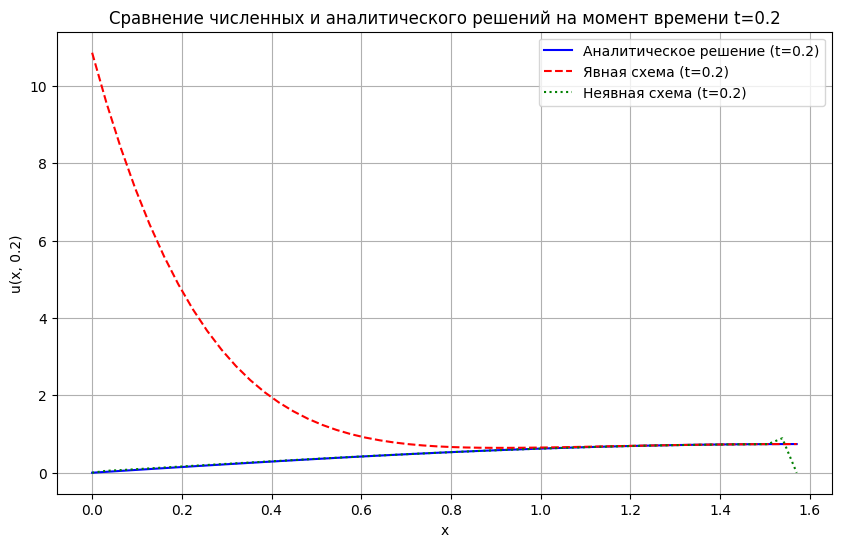

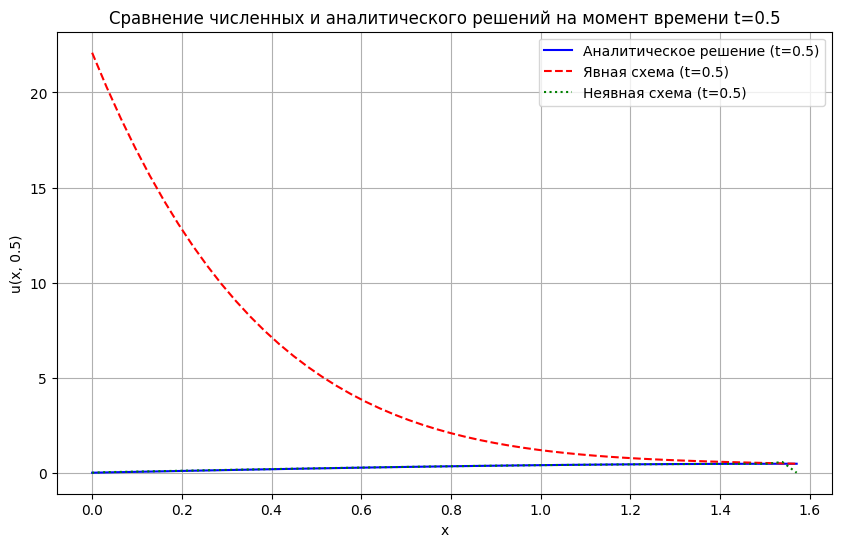

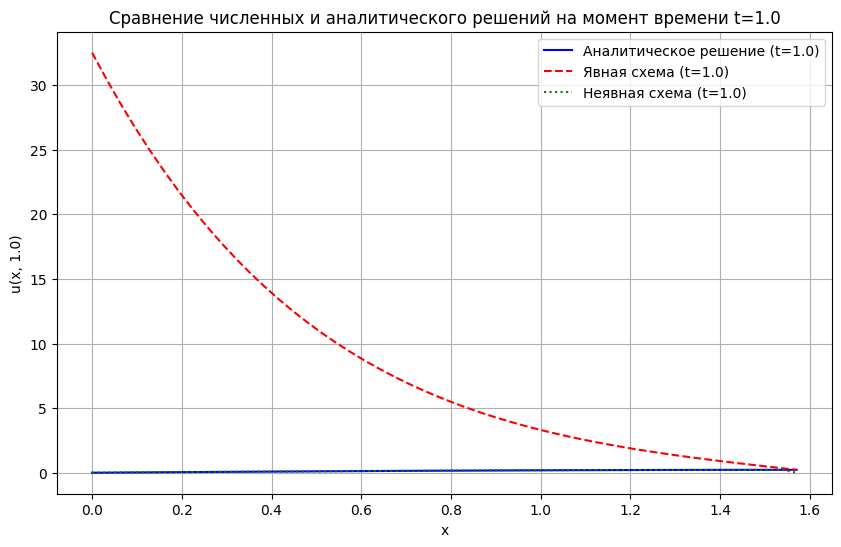

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve

# Параметры задачи
a = 0.4  # коэффициент диффузии
c = -1.1  # коэффициент c
L = np.pi / 2  # длина стержня
T = 1.0    # конечное время

# Аналитическое решение
def analytical_solution(x, t, a, c):
    return np.exp((c-a) * t) * np.sin(x)

# Начальные условия
def initial_condition(x):
    return np.sin(x)

# Граничные условия (u_x(0,t) = exp((c-a)t), u(L,t) = exp((c-a)t))
def ux0(t, c, a):
    return np.exp((c-a) * t)

def uL(t, c, a):
    return np.exp((c-a) * t)

# Явная схема
def explicit_scheme(Nx, Nt, dx, dt, x, t, a, c):
    u = np.zeros((Nt, Nx))
    u[0, :] = np.array([initial_condition(xi) for xi in x])

    for n in range(0, Nt-1):
        # Применение граничных условий с аппроксимацией второго порядка
        u[n+1, 0] = u[n, 0] + dx * ux0(t[n+1], c, a)

        for j in range(1, Nx-1):
            u[n+1, j] = u[n, j] + ((a * dt) * (u[n, j+1] - 2*u[n, j] + u[n, j-1])) / (dx ** 2) + c * dt * u[n, j]

        # Граничное условие на правой границе
        u[n+1, -1] = uL(t[n+1], c, a)

    return u

# Неявная схема
def implicit_scheme(Nx, Nt, alpha, x, t, a, c):
    u = np.zeros((Nt, Nx))
    u[0, :] = np.array([initial_condition(xi) for xi in x])

    A = np.zeros((Nx-2, Nx-2))
    for i in range(Nx-2):
        A[i, i] = 1 + 2 * alpha - c * dt
        if i > 0:
            A[i, i-1] = -alpha
        if i < Nx-3:
            A[i, i+1] = -alpha

    for n in range(0, Nt-1):
        # Применение граничного условия с аппроксимацией второго порядка
        b = u[n, 1:-1]
        b[0] += alpha * (u[n+1, 0] + dx * ux0(t[n+1], c, a))  # левая граница
        b[-1] += alpha * uL(t[n+1], c, a)  # правая граница
        u[n+1, 1:-1] = solve(A, b)

    return u

# Задаем число точек по пространству и пересчитываем шаги
Nx = 50  # число точек по пространству
dx = L / (Nx)  # шаг по пространству

# Условие стабильности
dt = 0.0005  # шаг по времени
Nt = int(T / dt)  # количество шагов по времени

# Сетки по x и t
x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

# Коэффициент для схемы
alpha = (a * dt) / (dx ** 2)
print(f"alpha: {alpha}")

# Вычисляем решение для каждой схемы
u_explicit = explicit_scheme(Nx, Nt, dx, dt, x, t, a, c)
u_implicit = implicit_scheme(Nx, Nt, alpha, x, t, a, c)

# Выбираем моменты времени для отображения
time_points = [0.2, 0.5, 1.0]
time_indices = [np.argmin(np.abs(t - tp)) for tp in time_points]

# Вычисляем аналитическое решение для всех моментов времени
u_analytical = np.array([[analytical_solution(xi, tn, a, c) for xi in x] for tn in t])

# Визуализация решений на выбранные моменты времени
for idx, tp in zip(time_indices, time_points):
    plt.figure(figsize=(10, 6))
    plt.plot(x, u_analytical[idx, :], label=f'Аналитическое решение (t={tp})', linestyle='-', color='b')
    plt.plot(x, u_explicit[idx, :], label=f'Явная схема (t={tp})', linestyle='--', color='r')
    plt.plot(x, u_implicit[idx, :], label=f'Неявная схема (t={tp})', linestyle=':', color='g')
    plt.xlabel('x')
    plt.ylabel(f'u(x, {tp})')
    plt.legend()
    plt.title(f'Сравнение численных и аналитического решений на момент времени t={tp}')
    plt.grid(True)
    plt.show()
